# Distribution des types de retours de service par joueur

Ce notebook est dédié à l'analyse de la distribution des différents types de retours de service (topspin, flip, poussette, bloc) pour chaque joueur.
L'objectif est de visualiser les préférences de style de jeu en retour de service pour chaque athlète.

---

## 1. Import des modules et connexion à la base de données

On commence par importer les modules nécessaires et se connecter à la base de données.

In [5]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configuration du style matplotlib pour LaTeX
plt.rcParams.update(
    {"font.size": 14, "text.usetex": True, "font.family": "serif"}
)

# Connexion à la base de données
con = sqlite3.connect("BDD_avec_cluster.db")

---

## 2. Fonctions d'extraction des données

Définition des fonctions pour extraire la liste des joueurs et calculer les pourcentages de chaque type de retour.

In [6]:
def get_joueurs(conn):
    """Récupère la liste des joueurs ayant effectué des retours."""
    query = (
        "SELECT DISTINCT joueur_frappe FROM Liste_des_coups WHERE num_coup = 2"
    )
    return [row[0] for row in conn.execute(query).fetchall()]


def get_pourcentages_retour(joueur, conn):
    """Calcule les pourcentages de chaque type de retour pour un joueur."""
    df = pd.read_sql_query(
        f"""
        SELECT effet_coup
        FROM Liste_des_coups
        WHERE num_coup = 2
          AND joueur_frappe = '{joueur}'
          AND effet_coup IS NOT NULL
        """,
        conn,
    )
    total = len(df)

    if total == 0:
        return [0, 0, 0, 0]

    types = ["topspin", "flip", "poussette", "bloc"]
    return [100 * (df["effet_coup"] == t).sum() / total for t in types]

---

## 3. Préparation des données

Récupération des données et construction du DataFrame avec les pourcentages pour chaque joueur.

In [7]:
# Récupération des données
joueurs = get_joueurs(con)
types_orig = ["topspin", "flip", "poussette", "bloc"]
labels_tex = [r"Topspin", r"Flip", r"Push shot", r"Block"]
couleurs = [
    "#d62728",
    "#1f77b4",
    "#2ca02c",
    "#ff7f0e",
]  # rouge, bleu, vert, orange

# Construction du DataFrame
data = {t: [] for t in types_orig}
for j in joueurs:
    pct = get_pourcentages_retour(j, con)
    for i, t in enumerate(types_orig):
        data[t].append(pct[i])

df = pd.DataFrame(data, index=joueurs)

# Tri par taux de topspin décroissant
df_sorted = df.sort_values(by="topspin", ascending=False)

---

## 4. Création de la figure

Génération du graphique en barres horizontales empilées montrant la distribution des types de retours pour chaque joueur.

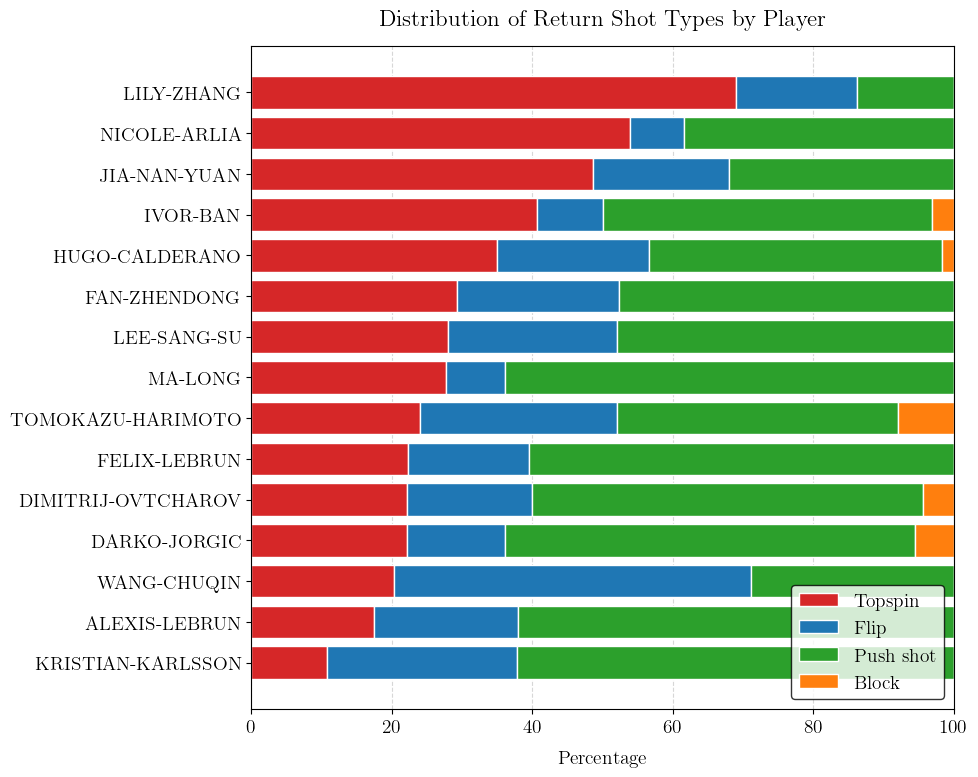

In [8]:
# Création de la figure
fig, ax = plt.subplots(figsize=(10, 8))
y_pos = np.arange(len(df_sorted))
left = np.zeros(len(df_sorted))

# Liste des joueurs triés
joueurs_tries = df_sorted.index.tolist()

# Tracé des barres empilées
for t, label, color in zip(types_orig, labels_tex, couleurs):
    ax.barh(
        y=y_pos,
        width=df_sorted[t],
        left=left,
        height=0.8,
        label=label,
        color=color,
        edgecolor="white",
    )
    left += df_sorted[t]

# Réglages finaux
ax.set_yticks(y_pos)
ax.set_yticklabels(joueurs_tries)
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_xlabel(r"Percentage", labelpad=10)
ax.set_title(r"Distribution of Return Shot Types by Player", pad=15)
ax.xaxis.grid(True, linestyle="--", alpha=0.5)
ax.set_axisbelow(True)

# Configuration de la légende
leg = ax.legend(loc="lower right", frameon=True)
leg.get_frame().set_edgecolor("black")

plt.tight_layout()

# Affichage de la figure
plt.show()

# Sauvegarde de la figure
# plt.savefig("images/percentage_type_return.svg")